In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Add, Average
from tensorflow.keras.metrics import Recall,Precision
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # tensorflow학습시 warning 숨김
import warnings
warnings.filterwarnings(action='ignore') # 그래프 그릴때 경고 메세지 안 보이게
plt.rc('font', family = 'AppleGothic')

In [2]:
asos_df = pd.read_csv('/Volumes/ESD-ISO/project_preson/shared_data_preparation/ASOS_1980_2024_After_drop.csv')

In [3]:
label_encoding_dict = {
    "no_clouds": 0,
    "Sc": 1,
    "Ci": 2,
    "ScAs": 3,
    "StNs": 4,
    "Ac": 5,
    "As": 6,
    "ScAc": 7,
    "ScCi": 8,
    "CuSc": 9,
    "AcCi": 10,
    "StAs": 11,
    "StSc": 12,
    "St": 13,
    "Cu": 14,
    "Cs": 15,
    "CuCi": 16,
    "ScNs": 17,
    "AsCi": 18,
    "CuAc": 19,
    "StCi": 20,
    "AcCs": 21,
    "ScCs": 22,
    "Cc": 23,
    "ScAcCi": 24,
    "CuAs": 25,
    "CsCi": 26,
    "AsAc": 27,
    "CbSt": 28,
    "CuSt": 29,
    "CbStNs": 30,
    "AcCc": 31,
    "AsCs": 32,
    "CbSc": 33,
    "CbCu": 34,
    "CbNs": 35,
    "Ns": 36,
    "ScCc": 37,
    "CuScCi": 38,
    "StAc": 39,
    "CcCi": 40,
    "CuScAs": 41,
    "CbAs": 42,
    "CuScAc": 43,
    "ScAcCs": 44,
    "Cb": 45,
    "CuScAcCi": 46,
    "CuScCc": 47,
    "CuCs": 48,
    "CbCi": 49,
    "CuAcCi": 50,
    "CuCc": 51,
    "ScAcCc": 52,
    "CuScCs": 53,
    "AsCc": 54,
    "ScCcCi": 55,
    "CbAc": 56,
    "CbCuNs": 57,
    "CuNs": 58,
    "CuScAsCi": 59,
    "ScAsCi": 60,
    "AcCcCi": 61,
    "CuScNs": 62,
    "AsSc": 63,
    "ScCu": 64,
    "CuScAcCc": 65,
    "CbScNs": 66,
    "CuScCcCi": 67,
    "CbScCs": 68,
    "CuCcCi": 69,
    "CuAcCc": 70,
    "StAsCi": 71,
    "CbScAs": 72,
    "ScAsCs": 73
}

In [4]:
asos_df['clfmAbbrCd'] = asos_df['clfmAbbrCd'].map(lambda x: label_encoding_dict[x])

In [5]:
asos_df['group'] = np.arange(len(asos_df)) // 24

In [6]:
asos_df

,tm,hm,pv,td,pa,clfmAbbrCd,lcsCh,m005Te,m01Te,m02Te,m03Te,rain,group
0,1980-01-01 01:00:00,NaN,3.700757,NaN,1013.876282,0,0.0,NaN,NaN,NaN,NaN,0,0
1,1980-01-01 02:00:00,NaN,3.700757,NaN,1013.876282,0,0.0,NaN,NaN,NaN,NaN,0,0
2,1980-01-01 03:00:00,56.000000,3.900000,-6.0,1015.900000,2,0.0,-1.200000,0.300000,0.500000,0.6,0,0
3,1980-01-01 04:00:00,58.333333,3.700757,-5.6,1013.876282,0,0.0,-1.083333,0.316667,0.483333,0.6,0,0
4,1980-01-01 05:00:00,60.666667,3.700757,-5.2,1013.876282,0,0.0,-0.966667,0.333333,0.466667,0.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127389,2024-12-30 21:00:00,67.000000,6.100000,0.0,1005.400000,2,36.5,-0.100000,-0.300000,0.800000,1.7,0,5307
127390,2024-12-30 22:00:00,71.000000,6.100000,0.0,1005.600000,0,0.0,-0.100000,-0.300000,0.800000,1.7,0,5307
127391,2024-12-30 23:00:00,75.000000,6.100000,0.0,1005.400000,0,0.0,-0.100000,-0.300000,0.800000,1.7,0,5307
127392,2024-12-31 00:00:00,81.000000,7.000000,1.8,1005.200000,0,0.0,-0.100000,-0.300000,0.800000,1.7,0,5308


In [7]:
def time_rain_whether_LSTM(time):
    return asos_df['rain'].shift(-time)

In [8]:
df_3h = asos_df.copy()
df_6h = asos_df.copy()
df_12h = asos_df.copy()
df_24h = asos_df.copy()

In [9]:
df_3h['hours_3'] = time_rain_whether_LSTM(3)
df_6h['hours_6'] = time_rain_whether_LSTM(6)
df_12h['hours_12'] = time_rain_whether_LSTM(12)
df_24h['hours_24'] = time_rain_whether_LSTM(24)

In [10]:
def processing_data(data, hours_col):
    data.drop(index=data[data.iloc[:,-1].isna()].index, inplace=True)
    group_sums = data.groupby('group')[hours_col].sum()
    groups_to_delete = group_sums[group_sums == 0].index
    groups_to_delete = groups_to_delete[:2500]
    filtered_df = data[~data['group'].isin(groups_to_delete)]
    other_columns_grouped = filtered_df.groupby('group')[['hm', 'td', 'pa', 'm005Te', 'm01Te', 'm02Te', 'm03Te', 'clfmAbbrCd', 'lcsCh']].apply(lambda x: x.values.tolist())
    hours_grouped = filtered_df.groupby('group')[hours_col].apply(list)
    y_data = []
    for hours in hours_grouped:
        if 1 in hours:
            y_data.append(1)
        else:
            y_data.append(0)
    data_X = np.vstack(other_columns_grouped.iloc[:-1].tolist())
#     print(data_X.shape)
    data_y = np.array(y_data[:-1])
#     print(data_y.shape)
    scaler = MinMaxScaler()
    data_X = scaler.fit_transform(data_X.reshape(-1,1)).reshape(-1,24,9)
    spilt_index = round(len(data_X)/10)*7
    train_X = data_X[:spilt_index]
    train_y = data_y[:spilt_index]
    test_X = data_X[spilt_index:]
    test_y = data_y[spilt_index:]
    return train_X,train_y,test_X,test_y

In [11]:
train_3h_X,train_3h_y,test_3h_X,test_3h_y = processing_data(df_3h,'hours_3')
train_6h_X,train_6h_y,test_6h_X,test_6h_y = processing_data(df_6h,'hours_6')
train_12h_X,train_12h_y,test_12h_X,test_12h_y = processing_data(df_12h,'hours_12')
train_24h_X,train_24h_y,test_24h_X,test_24h_y = processing_data(df_24h,'hours_24')

In [12]:
print(train_3h_X.shape,train_3h_y.shape,test_3h_X.shape,test_3h_y.shape)
print(train_6h_X.shape,train_6h_y.shape,test_6h_X.shape,test_6h_y.shape)
print(train_12h_X.shape,train_12h_y.shape,test_12h_X.shape,test_12h_y.shape)
print(train_24h_X.shape,train_24h_y.shape,test_24h_X.shape,test_24h_y.shape)

(1967, 24, 9) (1967,) (840, 24, 9) (840,)
(1967, 24, 9) (1967,) (840, 24, 9) (840,)
(1967, 24, 9) (1967,) (840, 24, 9) (840,)
(1967, 24, 9) (1967,) (840, 24, 9) (840,)


In [80]:
def lstm_model_V3():

    inputs = Input(shape=(24, 9))

    layer_1 = LSTM(units=32, return_sequences=True)(inputs)
    
    layer_2_1 = LSTM(units=32, return_sequences=False,
                     kernel_initializer='glorot_uniform',  # 가중치 초기화
                     recurrent_initializer='orthogonal',  # 순환 가중치 초기화
                     bias_initializer='zeros')(layer_1)
    layer_2_2 = LSTM(units=32, return_sequences=False,
                     kernel_initializer='glorot_uniform',  # 가중치 초기화
                     recurrent_initializer='orthogonal',  # 순환 가중치 초기화
                     bias_initializer='zeros')(inputs)
    second_layer = Add()([layer_2_1, layer_2_2])
    dropout_1 = Dropout(0.2)(second_layer)
    
    
    
    D_1 = Dense(units=128, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.2)(D_1)
    D_2 = Dense(units=256, activation='relu')(dropout_2)
    dropout_3 = Dropout(0.2)(D_2)
    D_3 = Dense(units=128, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.2)(D_3)
    D_4 = Dense(units=64, activation='relu')(dropout_4)
    dropout_5 = Dropout(0.2)(D_4)
    D_5 = Dense(units=32, activation='relu')(dropout_5)
    dropout_6 = Dropout(0.2)(D_5)
    
    outputs = Dense(units=1, activation='sigmoid')(dropout_6)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',Recall(),Precision()])
    return model

In [81]:
model_3h = lstm_model_V3()

model_3h.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 24, 9)]      0           []                               
                                                                                                  
 lstm_43 (LSTM)                 (None, 24, 32)       5376        ['input_18[0][0]']               
                                                                                                  
 lstm_44 (LSTM)                 (None, 32)           8320        ['lstm_43[0][0]']                
                                                                                                  
 lstm_45 (LSTM)                 (None, 32)           5376        ['input_18[0][0]']               
                                                                                           

In [82]:
model_6h = lstm_model_V3()

model_6h.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 24, 9)]      0           []                               
                                                                                                  
 lstm_46 (LSTM)                 (None, 24, 32)       5376        ['input_19[0][0]']               
                                                                                                  
 lstm_47 (LSTM)                 (None, 32)           8320        ['lstm_46[0][0]']                
                                                                                                  
 lstm_48 (LSTM)                 (None, 32)           5376        ['input_19[0][0]']               
                                                                                           

In [83]:
model_12h = lstm_model_V3()

model_12h.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 24, 9)]      0           []                               
                                                                                                  
 lstm_49 (LSTM)                 (None, 24, 32)       5376        ['input_20[0][0]']               
                                                                                                  
 lstm_50 (LSTM)                 (None, 32)           8320        ['lstm_49[0][0]']                
                                                                                                  
 lstm_51 (LSTM)                 (None, 32)           5376        ['input_20[0][0]']               
                                                                                           

In [84]:
model_24h = lstm_model_V3()

model_24h.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 24, 9)]      0           []                               
                                                                                                  
 lstm_52 (LSTM)                 (None, 24, 32)       5376        ['input_21[0][0]']               
                                                                                                  
 lstm_53 (LSTM)                 (None, 32)           8320        ['lstm_52[0][0]']                
                                                                                                  
 lstm_54 (LSTM)                 (None, 32)           5376        ['input_21[0][0]']               
                                                                                           

In [85]:
def get_checkpoint(hours_ahead, save_dir=os.getcwd()):
    file_name = hours_ahead + '_epoch-{epoch:02d}-acc-{accuracy:.4f}-val_acc-{val_accuracy:.4f}.h5'
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(save_dir,file_name), 
        monitor='val_accuracy',     
        save_best_only=True,        
        mode='max',                 
        verbose=1                   
    )
    return checkpoint

In [86]:
callbacks_3h = get_checkpoint(hours_ahead = '3h', save_dir='/Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/3h_models')
callbacks_6h = get_checkpoint(hours_ahead = '6h', save_dir='/Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/6h_models')
callbacks_12h = get_checkpoint(hours_ahead = '12h', save_dir='/Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/12h_models')
callbacks_24h = get_checkpoint(hours_ahead = '24h', save_dir='/Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/24h_models')

In [87]:
history_3h = model_3h.fit(train_3h_X,train_3h_y, validation_split=0.2, epochs=100, callbacks=callbacks_3h)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.7057 - recall_17: 0.9928 - precision_17: 0.7087
Epoch 1: val_accuracy improved from -inf to 0.30457, saving model to /Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/3h_models/3h_epoch-01-acc-0.7057-val_acc-0.3046.h5
50/50 [==============================] - 8s 98ms/step - loss: 0.6220 - accuracy: 0.7057 - recall_17: 0.9928 - precision_17: 0.7087 - val_loss: 0.8280 - val_accuracy: 0.3046 - val_recall_17: 1.0000 - val_precision_17: 0.3046
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.7088 - recall_17: 1.0000 - precision_17: 0.7088
Epoch 2: val_accuracy did not improve from 0.30457
50/50 [==============================] - 2s 33ms/step - loss: 0.6185 - accuracy: 0.7088 - recall_17: 1.0000 - precision_17: 0.7088 - val_loss: 0.9633 - val_accuracy: 0.3046 - val_recall_17: 1.0000 - val_precision_17: 0.3046
Epoch 3/100
50/50 [==============================] - ETA

Epoch 20/100
50/50 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8258 - recall_17: 0.8744 - precision_17: 0.8792
Epoch 20: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 29ms/step - loss: 0.3907 - accuracy: 0.8258 - recall_17: 0.8744 - precision_17: 0.8792 - val_loss: 0.8538 - val_accuracy: 0.5838 - val_recall_17: 0.8750 - val_precision_17: 0.4134
Epoch 21/100
50/50 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8258 - recall_17: 0.8771 - precision_17: 0.8771
Epoch 21: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 29ms/step - loss: 0.3823 - accuracy: 0.8258 - recall_17: 0.8771 - precision_17: 0.8771 - val_loss: 0.8236 - val_accuracy: 0.6396 - val_recall_17: 0.8167 - val_precision_17: 0.4495
Epoch 22/100
50/50 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8252 - recall_17: 0.8655 - precision_17: 0.8853
Epoch 22: val_accuracy did not 

Epoch 40/100
50/50 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.8411 - recall_17: 0.8987 - precision_17: 0.8797
Epoch 40: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 29ms/step - loss: 0.3643 - accuracy: 0.8411 - recall_17: 0.8987 - precision_17: 0.8797 - val_loss: 0.4935 - val_accuracy: 0.7741 - val_recall_17: 0.5750 - val_precision_17: 0.6449
Epoch 41/100
50/50 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8341 - recall_17: 0.8717 - precision_17: 0.8917
Epoch 41: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 29ms/step - loss: 0.3627 - accuracy: 0.8341 - recall_17: 0.8717 - precision_17: 0.8917 - val_loss: 0.5391 - val_accuracy: 0.7665 - val_recall_17: 0.7083 - val_precision_17: 0.5986
Epoch 42/100
50/50 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.8290 - recall_17: 0.8762 - precision_17: 0.8818
Epoch 42: val_accuracy did not 

Epoch 60/100
50/50 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8385 - recall_17: 0.8960 - precision_17: 0.8786
Epoch 60: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 30ms/step - loss: 0.3493 - accuracy: 0.8385 - recall_17: 0.8960 - precision_17: 0.8786 - val_loss: 0.5712 - val_accuracy: 0.7487 - val_recall_17: 0.7250 - val_precision_17: 0.5686
Epoch 61/100
49/50 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8380 - recall_17: 0.8868 - precision_17: 0.8852
Epoch 61: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 30ms/step - loss: 0.3530 - accuracy: 0.8379 - recall_17: 0.8870 - precision_17: 0.8846 - val_loss: 0.5782 - val_accuracy: 0.7310 - val_recall_17: 0.7917 - val_precision_17: 0.5398
Epoch 62/100
50/50 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8506 - recall_17: 0.8996 - precision_17: 0.8908
Epoch 62: val_accuracy did not 

Epoch 80/100
50/50 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8589 - recall_17: 0.8933 - precision_17: 0.9063
Epoch 80: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 28ms/step - loss: 0.3168 - accuracy: 0.8589 - recall_17: 0.8933 - precision_17: 0.9063 - val_loss: 0.5425 - val_accuracy: 0.7589 - val_recall_17: 0.6750 - val_precision_17: 0.5912
Epoch 81/100
48/50 [===========================>..] - ETA: 0s - loss: 0.3383 - accuracy: 0.8470 - recall_17: 0.8890 - precision_17: 0.8947
Epoch 81: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 28ms/step - loss: 0.3386 - accuracy: 0.8481 - recall_17: 0.8897 - precision_17: 0.8953 - val_loss: 0.8975 - val_accuracy: 0.6599 - val_recall_17: 0.8250 - val_precision_17: 0.4670
Epoch 82/100
49/50 [============================>.] - ETA: 0s - loss: 0.3268 - accuracy: 0.8571 - recall_17: 0.8885 - precision_17: 0.9081
Epoch 82: val_accuracy did not 

Epoch 100/100
49/50 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8635 - recall_17: 0.8940 - precision_17: 0.9120
Epoch 100: val_accuracy did not improve from 0.78680
50/50 [==============================] - 1s 29ms/step - loss: 0.2996 - accuracy: 0.8633 - recall_17: 0.8942 - precision_17: 0.9113 - val_loss: 0.7899 - val_accuracy: 0.5888 - val_recall_17: 0.8417 - val_precision_17: 0.4139


In [88]:
history_6h = model_6h.fit(train_6h_X,train_6h_y, validation_split=0.2, epochs=100, callbacks=callbacks_6h)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.6968 - recall_18: 0.9900 - precision_18: 0.7005
Epoch 1: val_accuracy improved from -inf to 0.29949, saving model to /Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/6h_models/6h_epoch-01-acc-0.6968-val_acc-0.2995.h5
50/50 [==============================] - 9s 102ms/step - loss: 0.6227 - accuracy: 0.6968 - recall_18: 0.9900 - precision_18: 0.7005 - val_loss: 0.8479 - val_accuracy: 0.2995 - val_recall_18: 1.0000 - val_precision_18: 0.2995
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.6999 - recall_18: 1.0000 - precision_18: 0.6999
Epoch 2: val_accuracy did not improve from 0.29949
50/50 [==============================] - 2s 30ms/step - loss: 0.6185 - accuracy: 0.6999 - recall_18: 1.0000 - precision_18: 0.6999 - val_loss: 0.9151 - val_accuracy: 0.2995 - val_recall_18: 1.0000 - val_precision_18: 0.2995
Epoch 3/100
50/50 [==============================] - ET

Epoch 20/100
49/50 [============================>.] - ETA: 0s - loss: 0.3890 - accuracy: 0.8265 - recall_18: 0.8871 - precision_18: 0.8681
Epoch 20: val_accuracy did not improve from 0.75127
50/50 [==============================] - 1s 29ms/step - loss: 0.3890 - accuracy: 0.8264 - recall_18: 0.8874 - precision_18: 0.8677 - val_loss: 0.5975 - val_accuracy: 0.7208 - val_recall_18: 0.7797 - val_precision_18: 0.5227
Epoch 21/100
50/50 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.8156 - recall_18: 0.8774 - precision_18: 0.8617
Epoch 21: val_accuracy improved from 0.75127 to 0.77157, saving model to /Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/6h_models/6h_epoch-21-acc-0.8156-val_acc-0.7716.h5
50/50 [==============================] - 2s 30ms/step - loss: 0.4079 - accuracy: 0.8156 - recall_18: 0.8774 - precision_18: 0.8617 - val_loss: 0.4973 - val_accuracy: 0.7716 - val_recall_18: 0.6271 - val_precision_18: 0.6167
Epoch 22/100
50/50 [=============================

50/50 [==============================] - 1s 29ms/step - loss: 0.3871 - accuracy: 0.8322 - recall_18: 0.8719 - precision_18: 0.8864 - val_loss: 0.6183 - val_accuracy: 0.6675 - val_recall_18: 0.8390 - val_precision_18: 0.4692
Epoch 40/100
50/50 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.8245 - recall_18: 0.9010 - precision_18: 0.8559
Epoch 40: val_accuracy did not improve from 0.77157
50/50 [==============================] - 1s 29ms/step - loss: 0.3890 - accuracy: 0.8245 - recall_18: 0.9010 - precision_18: 0.8559 - val_loss: 0.5093 - val_accuracy: 0.7640 - val_recall_18: 0.7373 - val_precision_18: 0.5839
Epoch 41/100
49/50 [============================>.] - ETA: 0s - loss: 0.3749 - accuracy: 0.8361 - recall_18: 0.8899 - precision_18: 0.8779
Epoch 41: val_accuracy did not improve from 0.77157
50/50 [==============================] - 1s 29ms/step - loss: 0.3756 - accuracy: 0.8353 - recall_18: 0.8901 - precision_18: 0.8766 - val_loss: 0.5352 - val_accuracy: 0.74

49/50 [============================>.] - ETA: 0s - loss: 0.3560 - accuracy: 0.8406 - recall_18: 0.8859 - precision_18: 0.8859
Epoch 59: val_accuracy did not improve from 0.77157
50/50 [==============================] - 2s 32ms/step - loss: 0.3557 - accuracy: 0.8404 - recall_18: 0.8856 - precision_18: 0.8864 - val_loss: 0.5841 - val_accuracy: 0.7335 - val_recall_18: 0.7881 - val_precision_18: 0.5376
Epoch 60/100
49/50 [============================>.] - ETA: 0s - loss: 0.3643 - accuracy: 0.8342 - recall_18: 0.8843 - precision_18: 0.8795
Epoch 60: val_accuracy did not improve from 0.77157
50/50 [==============================] - 1s 29ms/step - loss: 0.3640 - accuracy: 0.8347 - recall_18: 0.8847 - precision_18: 0.8799 - val_loss: 0.6617 - val_accuracy: 0.6472 - val_recall_18: 0.7966 - val_precision_18: 0.4498
Epoch 61/100
50/50 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8392 - recall_18: 0.8819 - precision_18: 0.8876
Epoch 61: val_accuracy did not improve from 

Epoch 79/100
49/50 [============================>.] - ETA: 0s - loss: 0.3540 - accuracy: 0.8348 - recall_18: 0.8780 - precision_18: 0.8852
Epoch 79: val_accuracy did not improve from 0.78934
50/50 [==============================] - 1s 29ms/step - loss: 0.3537 - accuracy: 0.8347 - recall_18: 0.8783 - precision_18: 0.8847 - val_loss: 0.6273 - val_accuracy: 0.6726 - val_recall_18: 0.8220 - val_precision_18: 0.4732
Epoch 80/100
49/50 [============================>.] - ETA: 0s - loss: 0.3372 - accuracy: 0.8438 - recall_18: 0.8843 - precision_18: 0.8916
Epoch 80: val_accuracy did not improve from 0.78934
50/50 [==============================] - 1s 28ms/step - loss: 0.3366 - accuracy: 0.8442 - recall_18: 0.8847 - precision_18: 0.8919 - val_loss: 0.8193 - val_accuracy: 0.6244 - val_recall_18: 0.8559 - val_precision_18: 0.4353
Epoch 81/100
50/50 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8519 - recall_18: 0.8856 - precision_18: 0.9011
Epoch 81: val_accuracy did not 

Epoch 99/100
50/50 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.8538 - recall_18: 0.8883 - precision_18: 0.9014
Epoch 99: val_accuracy did not improve from 0.78934
50/50 [==============================] - 1s 29ms/step - loss: 0.3147 - accuracy: 0.8538 - recall_18: 0.8883 - precision_18: 0.9014 - val_loss: 0.9055 - val_accuracy: 0.6269 - val_recall_18: 0.8729 - val_precision_18: 0.4383
Epoch 100/100
49/50 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8559 - recall_18: 0.8806 - precision_18: 0.9105
Epoch 100: val_accuracy did not improve from 0.78934
50/50 [==============================] - 1s 28ms/step - loss: 0.3128 - accuracy: 0.8563 - recall_18: 0.8810 - precision_18: 0.9108 - val_loss: 0.7468 - val_accuracy: 0.6599 - val_recall_18: 0.8390 - val_precision_18: 0.4626


In [89]:
history_12h = model_12h.fit(train_12h_X,train_12h_y, validation_split=0.2, epochs=100, callbacks=callbacks_12h)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.6942 - recall_19: 0.9802 - precision_19: 0.7031
Epoch 1: val_accuracy improved from -inf to 0.29695, saving model to /Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/12h_models/12h_epoch-01-acc-0.6942-val_acc-0.2970.h5
50/50 [==============================] - 8s 92ms/step - loss: 0.6255 - accuracy: 0.6942 - recall_19: 0.9802 - precision_19: 0.7031 - val_loss: 0.9476 - val_accuracy: 0.2970 - val_recall_19: 1.0000 - val_precision_19: 0.2970
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 0.6094 - accuracy: 0.7047 - recall_19: 1.0000 - precision_19: 0.7047
Epoch 2: val_accuracy did not improve from 0.29695
50/50 [==============================] - 2s 31ms/step - loss: 0.6093 - accuracy: 0.7050 - recall_19: 1.0000 - precision_19: 0.7050 - val_loss: 0.8374 - val_accuracy: 0.2970 - val_recall_19: 1.0000 - val_precision_19: 0.2970
Epoch 3/100
49/50 [============================>.] - E

Epoch 20/100
49/50 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.7934 - recall_19: 0.8671 - precision_19: 0.8442
Epoch 20: val_accuracy did not improve from 0.75381
50/50 [==============================] - 1s 29ms/step - loss: 0.4473 - accuracy: 0.7934 - recall_19: 0.8674 - precision_19: 0.8439 - val_loss: 0.7771 - val_accuracy: 0.6168 - val_recall_19: 0.8632 - val_precision_19: 0.4280
Epoch 21/100
49/50 [============================>.] - ETA: 0s - loss: 0.4356 - accuracy: 0.8010 - recall_19: 0.8643 - precision_19: 0.8550
Epoch 21: val_accuracy did not improve from 0.75381
50/50 [==============================] - 1s 29ms/step - loss: 0.4348 - accuracy: 0.8017 - recall_19: 0.8647 - precision_19: 0.8555 - val_loss: 0.7944 - val_accuracy: 0.6015 - val_recall_19: 0.8632 - val_precision_19: 0.4174
Epoch 22/100
49/50 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.7934 - recall_19: 0.8617 - precision_19: 0.8479
Epoch 22: val_accuracy did not 

50/50 [==============================] - 2s 30ms/step - loss: 0.4288 - accuracy: 0.7953 - recall_19: 0.8431 - precision_19: 0.8633 - val_loss: 0.7502 - val_accuracy: 0.6675 - val_recall_19: 0.8034 - val_precision_19: 0.4653
Epoch 40/100
49/50 [============================>.] - ETA: 0s - loss: 0.4186 - accuracy: 0.8055 - recall_19: 0.8606 - precision_19: 0.8630
Epoch 40: val_accuracy did not improve from 0.76650
50/50 [==============================] - 1s 30ms/step - loss: 0.4189 - accuracy: 0.8048 - recall_19: 0.8602 - precision_19: 0.8626 - val_loss: 0.8354 - val_accuracy: 0.5228 - val_recall_19: 0.8889 - val_precision_19: 0.3728
Epoch 41/100
49/50 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.7876 - recall_19: 0.8652 - precision_19: 0.8386
Epoch 41: val_accuracy did not improve from 0.76650
50/50 [==============================] - 2s 30ms/step - loss: 0.4462 - accuracy: 0.7877 - recall_19: 0.8647 - precision_19: 0.8390 - val_loss: 0.7768 - val_accuracy: 0.61

50/50 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.7978 - recall_19: 0.8521 - precision_19: 0.8599
Epoch 59: val_accuracy did not improve from 0.76650
50/50 [==============================] - 2s 30ms/step - loss: 0.4234 - accuracy: 0.7978 - recall_19: 0.8521 - precision_19: 0.8599 - val_loss: 0.6431 - val_accuracy: 0.7107 - val_recall_19: 0.7692 - val_precision_19: 0.5085
Epoch 60/100
50/50 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8175 - recall_19: 0.8638 - precision_19: 0.8757
Epoch 60: val_accuracy did not improve from 0.76650
50/50 [==============================] - 1s 29ms/step - loss: 0.4180 - accuracy: 0.8175 - recall_19: 0.8638 - precision_19: 0.8757 - val_loss: 0.7009 - val_accuracy: 0.6878 - val_recall_19: 0.7863 - val_precision_19: 0.4842
Epoch 61/100
49/50 [============================>.] - ETA: 0s - loss: 0.4259 - accuracy: 0.7953 - recall_19: 0.8446 - precision_19: 0.8625
Epoch 61: val_accuracy did not improve from 

Epoch 79/100
49/50 [============================>.] - ETA: 0s - loss: 0.4021 - accuracy: 0.8099 - recall_19: 0.8508 - precision_19: 0.8762
Epoch 79: val_accuracy did not improve from 0.76650
50/50 [==============================] - 1s 29ms/step - loss: 0.4017 - accuracy: 0.8099 - recall_19: 0.8512 - precision_19: 0.8757 - val_loss: 0.7997 - val_accuracy: 0.6066 - val_recall_19: 0.8547 - val_precision_19: 0.4202
Epoch 80/100
50/50 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8150 - recall_19: 0.8566 - precision_19: 0.8780
Epoch 80: val_accuracy did not improve from 0.76650
50/50 [==============================] - 1s 30ms/step - loss: 0.3965 - accuracy: 0.8150 - recall_19: 0.8566 - precision_19: 0.8780 - val_loss: 0.5857 - val_accuracy: 0.7513 - val_recall_19: 0.6752 - val_precision_19: 0.5683
Epoch 81/100
50/50 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.8017 - recall_19: 0.8575 - precision_19: 0.8606
Epoch 81: val_accuracy did not 

Epoch 99/100
49/50 [============================>.] - ETA: 0s - loss: 0.3906 - accuracy: 0.8099 - recall_19: 0.8533 - precision_19: 0.8738
Epoch 99: val_accuracy did not improve from 0.76650
50/50 [==============================] - 1s 30ms/step - loss: 0.3895 - accuracy: 0.8106 - recall_19: 0.8539 - precision_19: 0.8744 - val_loss: 0.7719 - val_accuracy: 0.6472 - val_recall_19: 0.8632 - val_precision_19: 0.4509
Epoch 100/100
48/50 [===========================>..] - ETA: 0s - loss: 0.3735 - accuracy: 0.8132 - recall_19: 0.8343 - precision_19: 0.8944
Epoch 100: val_accuracy did not improve from 0.76650
50/50 [==============================] - 1s 29ms/step - loss: 0.3749 - accuracy: 0.8137 - recall_19: 0.8368 - precision_19: 0.8923 - val_loss: 0.6831 - val_accuracy: 0.6980 - val_recall_19: 0.7521 - val_precision_19: 0.4944


In [90]:
history_24h = model_24h.fit(train_24h_X,train_24h_y, validation_split=0.2, epochs=100, callbacks=callbacks_24h)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.6955 - recall_20: 0.9855 - precision_20: 0.7015
Epoch 1: val_accuracy improved from -inf to 0.32487, saving model to /Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/24h_models/24h_epoch-01-acc-0.6955-val_acc-0.3249.h5
50/50 [==============================] - 10s 96ms/step - loss: 0.6350 - accuracy: 0.6955 - recall_20: 0.9855 - precision_20: 0.7015 - val_loss: 0.8298 - val_accuracy: 0.3249 - val_recall_20: 1.0000 - val_precision_20: 0.3249
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.7018 - recall_20: 1.0000 - precision_20: 0.7018
Epoch 2: val_accuracy did not improve from 0.32487
50/50 [==============================] - 2s 31ms/step - loss: 0.6149 - accuracy: 0.7018 - recall_20: 1.0000 - precision_20: 0.7018 - val_loss: 0.9412 - val_accuracy: 0.3249 - val_recall_20: 1.0000 - val_precision_20: 0.3249
Epoch 3/100
50/50 [==============================] - 

Epoch 20/100
49/50 [============================>.] - ETA: 0s - loss: 0.5172 - accuracy: 0.7105 - recall_20: 0.9009 - precision_20: 0.7418
Epoch 20: val_accuracy did not improve from 0.69036
50/50 [==============================] - 2s 31ms/step - loss: 0.5179 - accuracy: 0.7095 - recall_20: 0.8995 - precision_20: 0.7416 - val_loss: 0.7291 - val_accuracy: 0.5964 - val_recall_20: 0.7344 - val_precision_20: 0.4292
Epoch 21/100
50/50 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.7069 - recall_20: 0.8659 - precision_20: 0.7533
Epoch 21: val_accuracy did not improve from 0.69036
50/50 [==============================] - 1s 30ms/step - loss: 0.5243 - accuracy: 0.7069 - recall_20: 0.8659 - precision_20: 0.7533 - val_loss: 1.1448 - val_accuracy: 0.3249 - val_recall_20: 1.0000 - val_precision_20: 0.3249
Epoch 22/100
49/50 [============================>.] - ETA: 0s - loss: 0.5396 - accuracy: 0.7156 - recall_20: 0.9645 - precision_20: 0.7226
Epoch 22: val_accuracy did not 

Epoch 40/100
49/50 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.7647 - recall_20: 0.8261 - precision_20: 0.8375
Epoch 40: val_accuracy did not improve from 0.69036
50/50 [==============================] - 2s 30ms/step - loss: 0.4724 - accuracy: 0.7629 - recall_20: 0.8261 - precision_20: 0.8344 - val_loss: 0.7674 - val_accuracy: 0.5812 - val_recall_20: 0.6641 - val_precision_20: 0.4106
Epoch 41/100
50/50 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.7394 - recall_20: 0.8143 - precision_20: 0.8143
Epoch 41: val_accuracy did not improve from 0.69036
50/50 [==============================] - 1s 30ms/step - loss: 0.4939 - accuracy: 0.7394 - recall_20: 0.8143 - precision_20: 0.8143 - val_loss: 0.7893 - val_accuracy: 0.6371 - val_recall_20: 0.6484 - val_precision_20: 0.4586
Epoch 42/100
49/50 [============================>.] - ETA: 0s - loss: 0.5021 - accuracy: 0.7385 - recall_20: 0.8074 - precision_20: 0.8178
Epoch 42: val_accuracy did not 

Epoch 60/100
49/50 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.7672 - recall_20: 0.8447 - precision_20: 0.8274
Epoch 60: val_accuracy did not improve from 0.69036
50/50 [==============================] - 2s 30ms/step - loss: 0.4467 - accuracy: 0.7673 - recall_20: 0.8451 - precision_20: 0.8271 - val_loss: 0.6868 - val_accuracy: 0.6523 - val_recall_20: 0.5234 - val_precision_20: 0.4685
Epoch 61/100
49/50 [============================>.] - ETA: 0s - loss: 0.4573 - accuracy: 0.7583 - recall_20: 0.8253 - precision_20: 0.8291
Epoch 61: val_accuracy did not improve from 0.69036
50/50 [==============================] - 2s 31ms/step - loss: 0.4561 - accuracy: 0.7591 - recall_20: 0.8261 - precision_20: 0.8298 - val_loss: 0.7012 - val_accuracy: 0.6244 - val_recall_20: 0.5938 - val_precision_20: 0.4419
Epoch 62/100
49/50 [============================>.] - ETA: 0s - loss: 0.4586 - accuracy: 0.7691 - recall_20: 0.8492 - precision_20: 0.8267
Epoch 62: val_accuracy did not 

Epoch 80/100
49/50 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.7615 - recall_20: 0.8664 - precision_20: 0.8076
Epoch 80: val_accuracy did not improve from 0.69036
50/50 [==============================] - 1s 28ms/step - loss: 0.4600 - accuracy: 0.7622 - recall_20: 0.8668 - precision_20: 0.8083 - val_loss: 0.7187 - val_accuracy: 0.6218 - val_recall_20: 0.5469 - val_precision_20: 0.4348
Epoch 81/100
49/50 [============================>.] - ETA: 0s - loss: 0.4298 - accuracy: 0.7710 - recall_20: 0.8267 - precision_20: 0.8443
Epoch 81: val_accuracy did not improve from 0.69036
50/50 [==============================] - 1s 27ms/step - loss: 0.4297 - accuracy: 0.7718 - recall_20: 0.8270 - precision_20: 0.8446 - val_loss: 0.7393 - val_accuracy: 0.5685 - val_recall_20: 0.5859 - val_precision_20: 0.3906
Epoch 82/100
50/50 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.7654 - recall_20: 0.8306 - precision_20: 0.8344
Epoch 82: val_accuracy did not 

Epoch 100/100
50/50 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.7819 - recall_20: 0.8487 - precision_20: 0.8419
Epoch 100: val_accuracy improved from 0.69036 to 0.70051, saving model to /Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/24h_models/24h_epoch-100-acc-0.7819-val_acc-0.7005.h5
50/50 [==============================] - 2s 31ms/step - loss: 0.4263 - accuracy: 0.7819 - recall_20: 0.8487 - precision_20: 0.8419 - val_loss: 0.6216 - val_accuracy: 0.7005 - val_recall_20: 0.4766 - val_precision_20: 0.5446


In [91]:
eval_3h = model_3h.evaluate(test_3h_X, test_3h_y)
print('{:.2f}% accuracy'.format(eval_3h[1]*100))

27/27 [==============================] - 1s 29ms/step - loss: 0.7047 - accuracy: 0.6274 - recall_17: 0.7992 - precision_17: 0.4248
62.74% accuracy


In [92]:
eval_6h = model_6h.evaluate(test_6h_X, test_6h_y)
print('{:.2f}% accuracy'.format(eval_3h[1]*100))

27/27 [==============================] - 1s 31ms/step - loss: 0.6572 - accuracy: 0.6452 - recall_18: 0.7969 - precision_18: 0.4533
62.74% accuracy


In [93]:
eval_12h = model_12h.evaluate(test_12h_X, test_12h_y)
print('{:.2f}% accuracy'.format(eval_3h[1]*100))

27/27 [==============================] - 1s 33ms/step - loss: 0.6960 - accuracy: 0.6643 - recall_19: 0.6488 - precision_19: 0.4435
62.74% accuracy


In [94]:
eval_24h = model_24h.evaluate(test_24h_X, test_24h_y)
print('{:.2f}% accuracy'.format(eval_3h[1]*100))

27/27 [==============================] - 1s 32ms/step - loss: 0.6084 - accuracy: 0.7012 - recall_20: 0.4050 - precision_20: 0.4780
62.74% accuracy


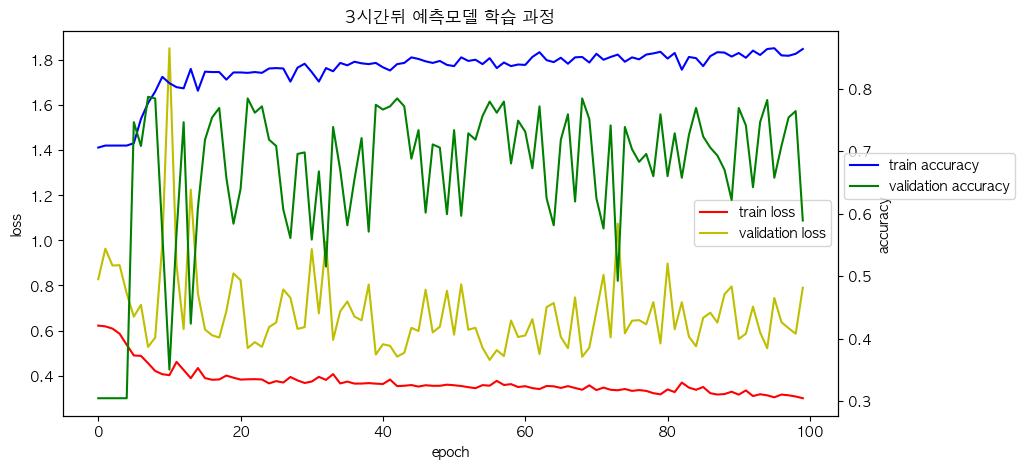

In [95]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(history_3h.history['loss'], 'r', label='train loss')
loss_ax.plot(history_3h.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(history_3h.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history_3h.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.title('3시간뒤 예측모델 학습 과정')
plt.show()

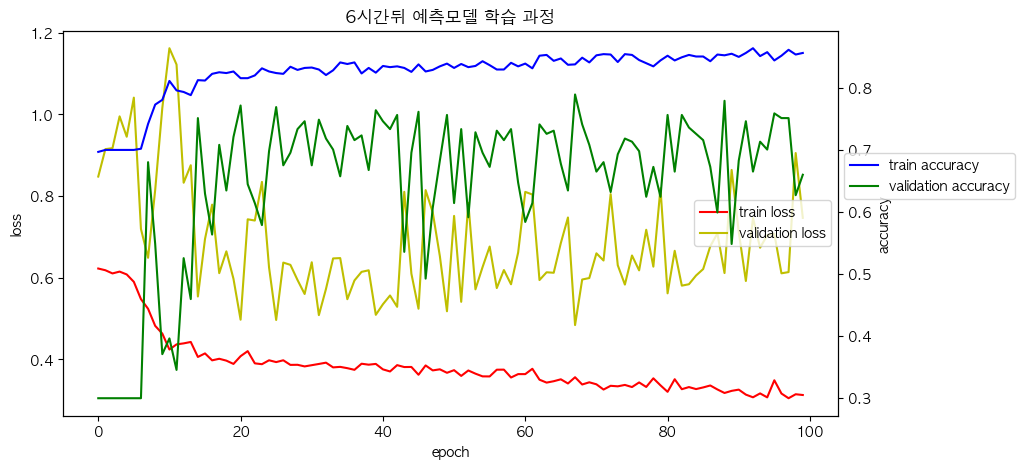

In [109]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(history_6h.history['loss'], 'r', label='train loss')
loss_ax.plot(history_6h.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(history_6h.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history_6h.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.title('6시간뒤 예측모델 학습 과정')
plt.show()

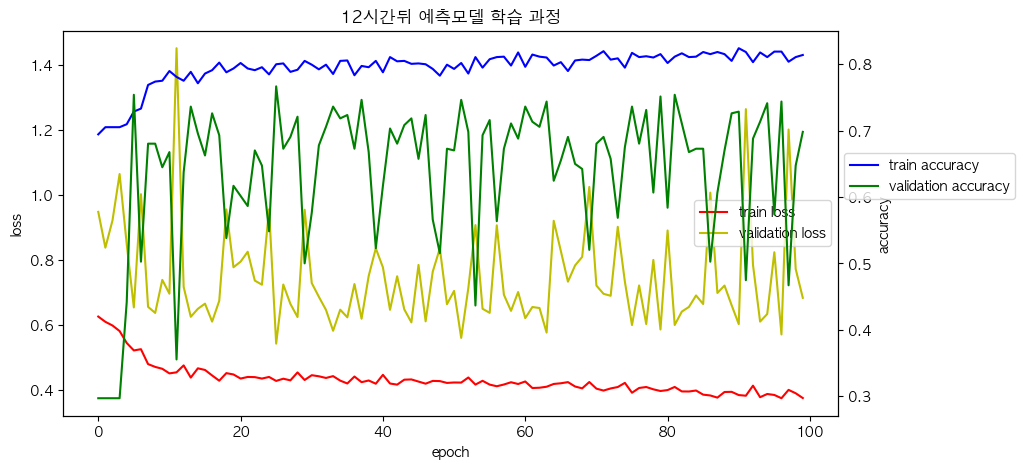

In [108]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(history_12h.history['loss'], 'r', label='train loss')
loss_ax.plot(history_12h.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(history_12h.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history_12h.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.title('12시간뒤 예측모델 학습 과정')
plt.show()

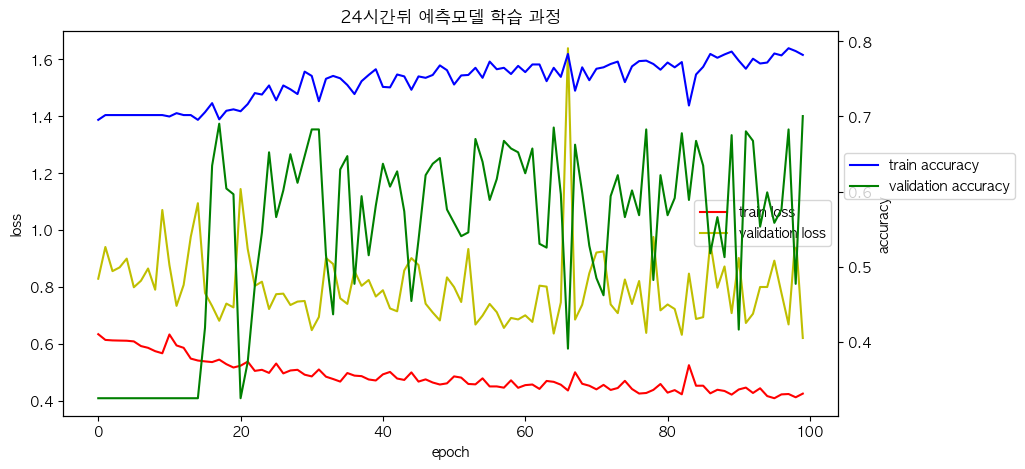

In [107]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(history_24h.history['loss'], 'r', label='train loss')
loss_ax.plot(history_24h.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(history_24h.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history_24h.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.title('24시간뒤 예측모델 학습 과정')
plt.show()

In [110]:
from tensorflow.keras.models import load_model # 저장된 모델 평가하기 

load_model_3h = load_model('/Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/3h_models/3h_epoch-93-acc-0.8595-val_acc-0.7893.h5')

eval_3h = load_model_3h.evaluate(test_3h_X, test_3h_y)
print('{:.2f}% accuracy'.format(eval_3h[1]*100))

27/27 [==============================] - 2s 36ms/step - loss: 0.4845 - accuracy: 0.8119 - recall_9: 0.6393 - precision_9: 0.6903
81.19% accuracy


In [111]:
load_model_6h = load_model('/Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/6h_models/6h_epoch-68-acc-0.8379-val_acc-0.7893.h5')

eval_6h = load_model_6h.evaluate(test_6h_X, test_6h_y)
print('{:.2f}% accuracy'.format(eval_6h[1]*100))

27/27 [==============================] - 2s 35ms/step - loss: 0.4667 - accuracy: 0.8071 - recall_18: 0.5938 - precision_18: 0.7238
80.71% accuracy


In [112]:
load_model_12h = load_model('/Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/12h_models/12h_epoch-93-acc-0.8156-val_acc-0.7741.h5')

eval_12h = load_model_12h.evaluate(test_12h_X, test_12h_y)
print('{:.2f}% accuracy'.format(eval_12h[1]*100))

27/27 [==============================] - 2s 37ms/step - loss: 0.5556 - accuracy: 0.7548 - recall_11: 0.5248 - precision_11: 0.5826
75.48% accuracy


In [118]:
load_model_24h = load_model('/Volumes/ESD-ISO/project_preson/LSTM/LSTM_models/24h_models/24h_epoch-100-acc-0.7819-val_acc-0.7005.h5')

eval_24h = load_model_24h.evaluate(test_24h_X, test_24h_y)
print('{:.2f}% accuracy'.format(eval_24h[1]*100))

27/27 [==============================] - 2s 37ms/step - loss: 0.6084 - accuracy: 0.7012 - recall_20: 0.4050 - precision_20: 0.4780
70.12% accuracy


In [124]:
y_hat = (load_model_3h.predict(test_3h_X) > 0.5).astype(int).reshape(-1)
c_tap_3h = pd.crosstab(y_hat, test_3h_y)
c_tap_3h.index.name = '예측값'
c_tap_3h.columns.name = '실제값'
c_tap_3h

27/27 [==============================] - 0s 11ms/step


실제값,0,1
예측값,,
0,513,122
1,83,122


In [127]:
y_hat = (load_model_6h.predict(test_6h_X) > 0.5).astype(int).reshape(-1)
c_tap_6h = pd.crosstab(y_hat, test_6h_y)
c_tap_6h.index.name = '예측값'
c_tap_6h.columns.name = '실제값'
c_tap_6h

27/27 [==============================] - 0s 11ms/step


실제값,0,1
예측값,,
0,526,104
1,58,152


In [129]:
y_hat = (load_model_12h.predict(test_12h_X) > 0.5).astype(int).reshape(-1)
c_tap_12h = pd.crosstab(y_hat, test_12h_y)
c_tap_12h.index.name = '예측값'
c_tap_12h.columns.name = '실제값'
c_tap_12h

27/27 [==============================] - 0s 11ms/step


실제값,0,1
예측값,,
0,507,115
1,91,127


In [131]:
y_hat = (load_model_24h.predict(test_24h_X) > 0.5).astype(int).reshape(-1)
c_tap_24h = pd.crosstab(y_hat, test_24h_y)
c_tap_24h.index.name = '예측값'
c_tap_24h.columns.name = '실제값'
c_tap_24h

27/27 [==============================] - 0s 11ms/step


실제값,0,1
예측값,,
0,491,144
1,107,98


In [125]:
f1_score_3h = f1_score(y_hat,test_3h_y)
f1_score_3h

0.5434298440979954

In [128]:
f1_score_6h = f1_score(y_hat,test_6h_y)
f1_score_6h

0.6523605150214591

In [130]:
f1_score_12h = f1_score(y_hat,test_12h_y)
f1_score_12h

0.5521739130434783

In [132]:
f1_score_24h = f1_score(y_hat,test_24h_y)
f1_score_24h

0.43847874720357943